# 1. Import Libraries and Dataset

In [1]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# Load raw participants data
raw_data_path = "Cleaned_Activity_Level_Dataset.xlsx"  
participants_data = pd.read_excel(raw_data_path)

In [3]:
participants_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                     --------------  -----  
 0   ID                                                                                                         41 non-null     int64  
 1   I have read and understood the purpose of this study                                                       41 non-null     object 
 2   I understand that my participation is voluntary, and I can withdraw at any time without any consequences.  41 non-null     object 
 3   I agree to participate in this study.                                                                      41 non-null     object 
 4   Participant ID                                                              

# 2. Data Pre-Processing

## 2.1 Column Names Mapping

In [4]:
# Renaming columns based on your mapping
column_mapping = {
    "Average Resting Heart Rate (bpm) (Refer to the Information Sheet for measuring guidance)": "fitbit_resting_heart_rate",
    "Daily Average Step Count (Refer to the Information Sheet for measuring guidance)": "fitbit_steps",
    "Height (in cm)": "height_cm",
    "Weight (in kg)": "weight_kg",
    "If you realized you received too much change, you would feel obligated to return it immediately": "Honesty/Humility",
    "I find it difficult to stay calm when faced with minor inconveniences.": "Negative Emotionality",
    "I feel comfortable starting conversations in a room full of unfamiliar people.": "Extraversion",
    "I would try to remain open and respectful when discussing a topic I strongly disagree on with a friend.": "Agreeableness",
    "I begin working on tasks with deadlines well in advance to avoid last-minute stress.": "Conscientiousness",
    "I feel excited to try new restaurants or cuisines, even if they are unfamiliar to me.": "Openness to Experiences",
}
participants_data.rename(columns=column_mapping, inplace=True)

In [5]:
# Combine all required columns into a new dataframe
final_columns = [
    "fitbit_resting_heart_rate",
    "Honesty/Humility",
    "Negative Emotionality",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Openness to Experiences",
    "fitbit_steps",
    "weight_kg",
    "height_cm"
]
final_dataframe = participants_data[final_columns].copy()

In [6]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fitbit_resting_heart_rate  41 non-null     float64
 1   Honesty/Humility           41 non-null     object 
 2   Negative Emotionality      41 non-null     object 
 3   Extraversion               41 non-null     object 
 4   Agreeableness              41 non-null     object 
 5   Conscientiousness          41 non-null     object 
 6   Openness to Experiences    41 non-null     object 
 7   fitbit_steps               41 non-null     int64  
 8   weight_kg                  41 non-null     int64  
 9   height_cm                  41 non-null     float64
dtypes: float64(2), int64(2), object(6)
memory usage: 3.3+ KB


## 2.2 Outliers Handling

Outliers in fitbit_resting_heart_rate:
    fitbit_resting_heart_rate Honesty/Humility Negative Emotionality  \
14                      165.0            Agree               Neutral   
15                        0.0          Neutral               Neutral   
21                      130.0          Neutral     Strongly disagree   
23                        0.0         Disagree               Neutral   
38                       11.0            Agree                 Agree   

   Extraversion      Agreeableness Conscientiousness Openness to Experiences  \
14     Disagree            Neutral          Disagree       Strongly disagree   
15        Agree           Disagree          Disagree                 Neutral   
21      Neutral  Strongly disagree             Agree                 Neutral   
23        Agree            Neutral             Agree                   Agree   
38        Agree              Agree             Agree                   Agree   

    fitbit_steps  weight_kg  height_cm  
14    

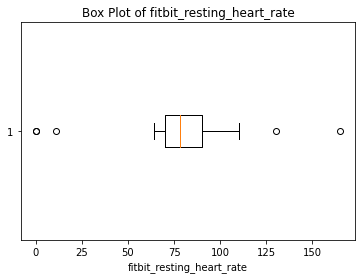

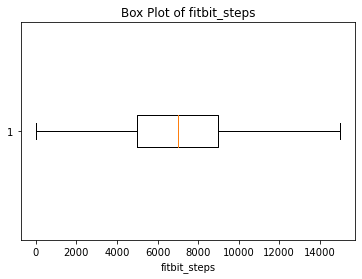

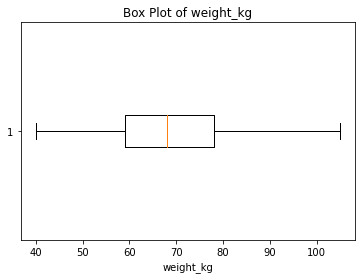

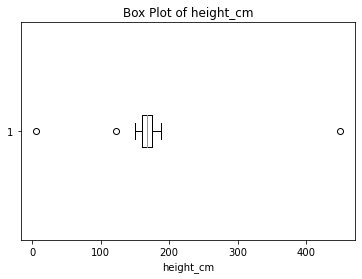

In [7]:
import matplotlib.pyplot as plt

# Numeric columns in the final dataframe
numeric_columns = ["fitbit_resting_heart_rate","fitbit_steps","weight_kg","height_cm"]

# Detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Checking for outliers in each numeric column
outliers_summary = {}
for column in numeric_columns:
    outliers = detect_outliers_iqr(final_dataframe, column)
    outliers_summary[column] = outliers

# Displaying outliers
for column, outliers in outliers_summary.items():
    print(f"Outliers in {column}:")
    print(outliers if not outliers.empty else "No outliers detected.")
    print("\n")

# Visualizing outliers using box plots
for column in numeric_columns:
    plt.figure()
    plt.boxplot(final_dataframe[column].dropna(), vert=False)
    plt.title(f"Box Plot of {column}")
    plt.xlabel(column)
    plt.show()


In [8]:
# Replace 0.0 in `fitbit_resting_heart_rate` with the column median
median_heart_rate = final_dataframe["fitbit_resting_heart_rate"].replace(0, np.nan).median()
final_dataframe["fitbit_resting_heart_rate"] = final_dataframe["fitbit_resting_heart_rate"].replace(0, median_heart_rate)

In [9]:
# Correct extreme values in `height_cm`
# Assuming `5.11` is in feet, convert to cm: (5 * 30.48) + (11 * 2.54)
final_dataframe["height_cm"] = final_dataframe["height_cm"].replace(5.11, (5 * 30.48) + (11 * 2.54))

# Replace outlier height values (e.g., 450.0 cm) with the median
median_height = final_dataframe.loc[final_dataframe["height_cm"] < 250, "height_cm"].median()  # Assume valid heights < 250 cm
final_dataframe["height_cm"] = final_dataframe["height_cm"].apply(lambda x: median_height if x > 250 else x)

## 2.3 Feature Engineering (Calculating BMI)

In [10]:
# Recalculate BMI after correcting heights
final_dataframe["bmi"] = final_dataframe["weight_kg"] / (final_dataframe["height_cm"] / 100) ** 2

In [11]:
# Verify and remove rows with extreme BMI values if necessary
final_dataframe = final_dataframe[final_dataframe["bmi"] < 60]  # Removing unrealistically high BMI values

## 2.4 Handling Null/ Missing Values

In [12]:
# Ensure you're working on a copy of the DataFrame
final_dataframe = final_dataframe.copy()

# Check for and replace negative or zero values in `fitbit_steps` using .loc
final_dataframe.loc[:, "fitbit_steps"] = final_dataframe["fitbit_steps"].apply(lambda x: np.nan if x <= 0 else x)

# Calculate the median of `fitbit_steps` excluding NaN
median_steps = final_dataframe["fitbit_steps"].median()

# Fill NaN values in `fitbit_steps` with the median
final_dataframe.loc[:, "fitbit_steps"] = final_dataframe["fitbit_steps"].fillna(median_steps)

## 2.5 Converting Float to Int

In [13]:
# Round the 'fitbit_resting_heart_rate' column to remove decimals
final_dataframe["fitbit_resting_heart_rate"] = final_dataframe["fitbit_resting_heart_rate"].round(0).astype(int)

In [14]:
# Round the 'fitbit_steps' column to remove decimals
final_dataframe["fitbit_steps"] = final_dataframe["fitbit_steps"].round(0).astype(int)

In [15]:
# Round the 'weight_kg' column to remove decimals
final_dataframe["weight_kg"] = final_dataframe["weight_kg"].round(0).astype(int)

In [16]:
# Round the 'height_cm' column to remove decimals
final_dataframe["height_cm"] = final_dataframe["height_cm"].round(0).astype(int)

## 2.6 Mapping Categorical Traits into Numerical Values

In [23]:
# Mapping dictionary
mapping = {
    'Strongly disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly agree': 5
}

# Columns to normalize
columns_to_normalize = [
    'Honesty/Humility',
    'Negative Emotionality',
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness to Experiences'
]

# Normalize the columns
for column in columns_to_normalize:
    final_dataframe[column] = final_dataframe[column].map(mapping)

In [24]:
final_dataframe.head()

,fitbit_resting_heart_rate,Honesty/Humility,Negative Emotionality,Extraversion,Agreeableness,Conscientiousness,Openness to Experiences,fitbit_steps,weight_kg,height_cm,bmi
0,64,4,3,3,4,3,3,12004,55,164,20.325015
1,67,3,3,3,3,4,4,9797,60,158,24.187453
2,70,5,2,4,3,4,4,8000,74,171,25.306932
3,72,2,3,3,3,4,4,8000,70,164,26.026175
4,78,4,4,4,4,5,2,5000,83,180,25.520781


# 3. Deployment

## 3.1 Defining Features

In [25]:
# Define the correct column order used during training
correct_column_order = [
    'fitbit_resting_heart_rate',
    'bmi',
    'Honesty/Humility',
    'Negative Emotionality',
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness to Experiences'
]

In [27]:
# Reorder columns to match training
X_test = final_dataframe[correct_column_order]

## 3.2 Loading Best Model

In [28]:
# Load the trained model
model_file_path = 'stacking_clf_final.pkl'
loaded_model = joblib.load(model_file_path)

## 3.3 Make Predictions 

In [29]:
# Make predictions
y_pred = loaded_model.predict(X_test)

In [30]:
y_pred

array(['Active', 'Active', 'Sedentary', 'Moderately Active',
       'Moderately Active', 'Active', 'Moderately Active',
       'Moderately Active', 'Sedentary', 'Active', 'Active', 'Active',
       'Moderately Active', 'Active', 'Moderately Active', 'Active',
       'Moderately Active', 'Sedentary', 'Moderately Active', 'Active',
       'Sedentary', 'Active', 'Moderately Active', 'Active',
       'Moderately Active', 'Moderately Active', 'Active', 'Sedentary',
       'Active', 'Moderately Active', 'Active', 'Moderately Active',
       'Active', 'Active', 'Moderately Active', 'Sedentary',
       'Moderately Active', 'Sedentary', 'Active', 'Active', 'Sedentary'],
      dtype=object)

# 4. Update Participants dataset with new columns ('bmi','activity_level')

In [31]:
# Add the y_pred as a new column in the dataframe
participants_data['Activity_Level'] = y_pred

In [44]:
participants_data['bmi'] = final_dataframe['bmi'].values

In [47]:
# Replace the fitbit_resting_heart_rate column with values from the final dataframe
participants_data['fitbit_resting_heart_rate'] = final_dataframe['fitbit_resting_heart_rate'].values

In [48]:
participants_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 29 columns):
 #   Column                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                     --------------  -----  
 0   ID                                                                                                         41 non-null     int64  
 1   I have read and understood the purpose of this study                                                       41 non-null     object 
 2   I understand that my participation is voluntary, and I can withdraw at any time without any consequences.  41 non-null     object 
 3   I agree to participate in this study.                                                                      41 non-null     object 
 4   Participant ID                                                              

In [49]:
participants_data.to_csv('Final_data_participants.csv', index=False)